# Intensity distribution estimation through mixture models

In [147]:
import numpy as np

# file manipulation
from glob import glob

# image processing
from skimage.io import imread

# stats utils
from scipy.stats import *

# sonar utils
import sonar, didson

# plot results
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def computeHist(image_list, correct=False, bp=np.ones(96), at=np.ones(512)):
    N = len(image_list)
    h = np.zeros(255)
    bins = np.linspace(0, 1.0, 256 ) 
    x = np.array([])
    
    for idx in range(0,N):
        # read image
        image = (1/255.0)*imread(image_list[idx],as_grey = True)
#         if correct:
#             image = removeBPR(image, bp, at)
        x = np.hstack((x, image.flatten()))
        # compute histogram
        hi = np.histogram(image[:],bins)

        # add it to total
        h += hi[0]
        
    print np.amin(image.flatten()), np.amax(image.flatten())
    
    return (h, bins, x) 

In [34]:
image_list_1 = glob('../data/dataset-1/*raw.png') # 10 test images
print len(image_list_1)
image_list_2 = glob('../data/dataset-2/*raw.png') # window set to 2.5m to 11.5m
print len(image_list_2)
image_list_3 = glob('../data/dataset-3/*raw.png') # 
print len(image_list_3)
# image_list_4 = glob('./data/DIDSON/2016-07-19.11/*raw.png') # 
# print len(image_list_4)

# background
h_test, h_test_bins, x_test = computeHist(image_list_1)

# background
h_bg, h_bg_bins, x_bg = computeHist(image_list_2)


# test 
# N = 2*len(image_list_3)
# image_list = np.array(image_list_4)
# idx = np.random.randint(0, len(image_list), N)
# h_test, h_test_bins, x_test = computeHist(image_list[idx])

10
116
270
0.0 0.525490196078
0.0 0.192156862745


## Background distribution

In [35]:
def kld(sample, reference):
    p = sample
    q = reference    
    q[np.where(q==0)[0]] = 1 # we're dividing by q, so set all zero-values to 1
    r = p/q
    r[np.where(r==0)[0]] = 1 # ln(1) = 0; ln(0)=nan

    return np.sum(p*np.log(r)) # kld wrt background

scale*:  0.018 with K-L divergence of 0.0486180671792 (lambda= 55.5555555556 )


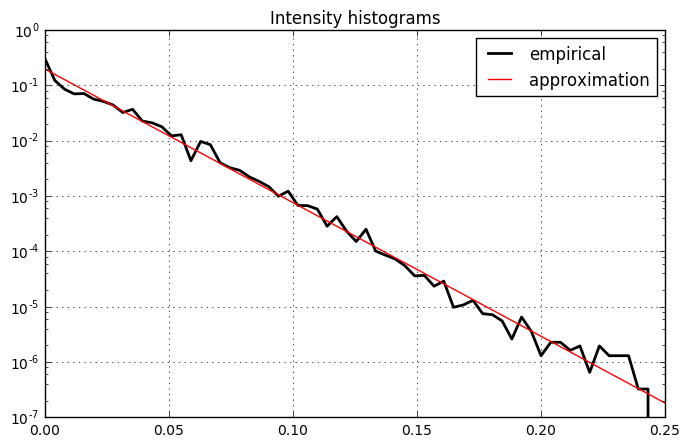

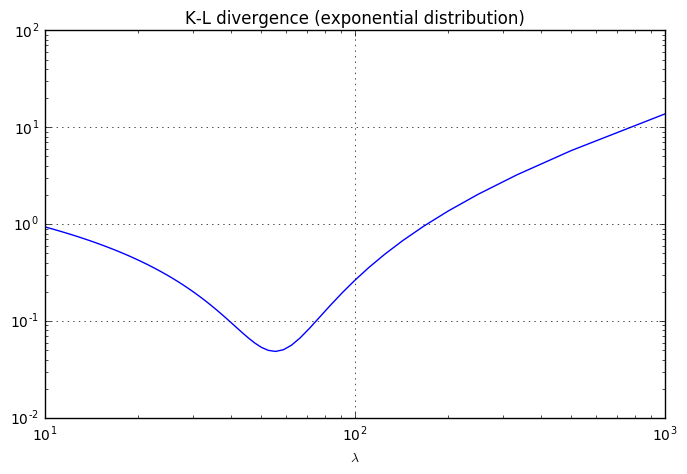

In [153]:
x = h_bg_bins[:-1]
# estimation of the background distribution is heavily biased by abnormally high probability of 0 intensity 
# insufficient gain?
h_bg[0]=0.3 # oof
h_bg/=np.sum(h_bg)


plt.figure(figsize=(8,5))
plt.xlim([0,.25])
plt.ylim([1e-7,1e0]) # lower bound: 1 in 116 scans x 49152 px/scan ~ 1e-7
plt.yscale('log')
plt.grid() 
plt.title('Intensity histograms')

plt.plot(x, h_bg ,color='k',linewidth=2.0)
L = np.arange(0.001, 0.1, 0.001)
k = np.zeros_like(L)
for i in range(0,len(L)):
    p1 = expon.pdf(x,0,L[i]) # note: scale is the inverse of lambda
    p1/=np.sum(p1)
#     plt.plot(x, p1, color='c', linewidth=1.0)
    k[i] = kld(h_bg, p1)
#     print L[i], k[i]

print 'scale*: ', L[np.argmin(k)], 'with K-L divergence of',np.min(k), '(lambda=',1.0/L[np.argmin(k)],')'

p_bg = expon.pdf(x, 0, L[np.argmin(k)])
p_bg/=np.sum(p_bg)
# p_bg = expon.pdf(x, 0, L[np.argmin(k)])
plt.plot(x, p_bg, color='r',linewidth=1.0)
plt.legend(('empirical','approximation'))
    
plt.figure(figsize=(8,5))
plt.plot(1.0/L,k) # scale is the inverse of lambda
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.title('K-L divergence (exponential distribution)')
plt.xlabel('$\lambda$')
plt.show()

## Object intensity distribution 

K-L divergence: 0.416388769112


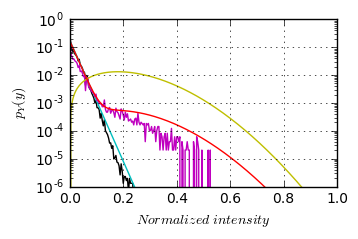

In [156]:
# background
h_bg = h_bg/np.sum(h_bg)     # histogram
# print 'h_bg', np.sum(h_bg)
p_bg = expon.pdf(x, 0, 0.02)  # theoretical distribution (normalized)
p_bg/=np.sum(p_bg)
# print 'p_bg:', np.sum(p_bg)

# object + background
h_test = h_test/np.sum(h_test) 

# Object distribution
# p_o =  expon.pdf(x, 0.0, 0.2);
p_o = rayleigh.pdf(x, 0.0, 0.18)
p_o/=np.sum(p_o) # discrete pdf has to sum to 1

p_t = 0.96*p_bg + 0.04*p_o
p_t/=np.sum(p_t)

# figure setup
plt.figure(figsize=(3.45,3.45*5/8.0))
plt.xlim([0,1])
plt.ylim([1e-6,1e0])
plt.yscale('log')
plt.grid()
# plt.title('Intensity histograms')
plt.plot(x, h_bg ,color='k',linewidth=1.0)
plt.plot(x, p_bg, color='c', linewidth=1.0)
plt.plot(x, h_test, color='m', linewidth=1.0)
plt.plot(x, p_o, color='y', linewidth=1.0)
plt.plot(x, p_t, color='r', linewidth=1.0)
plt.ylabel('$p_Y(y)$')
plt.xlabel('$Normalized\ intensity$')
plt.savefig('mixture.eps',dpi=600,bbox_inches='tight',transparent=True)
# plt.savefig('mixture.pdf',bbox_inches='3')
# print sum(p)
# print sum(q)
# print(sum(p_o))
# plt.legend(('bg','bga', 'test','object','estimate'))

print 'K-L divergence:',kld(h_test,p_t)

In [158]:
def grid_search_fit(x, h_test,N=100):

    pi = np.linspace(0.7,1.0,N)
    s = np.linspace(0.1,0.3,N)

    k = np.zeros((len(pi),len(s)))
    
    p_bg = expon.pdf(x, 0, 0.018)  # theoretical distribution (normalized)
    p_bg/=np.sum(p_bg)

    for i in range(0,len(pi)):
        for j in range(0,len(s)):
            p_o = rayleigh.pdf(x, 0.0, s[j])
            p_o/=np.sum(p_o) # discrete pdf has to sum to 1

            p_t = pi[i]*p_bg + (1-pi[i])*p_o
            p_t/=np.sum(p_t)
            k[i,j] = kld(h_test,p_t)

    return(pi, s, k)

pi: 0.972727272727
s: 0.134343434343
kld: 0.377965907233


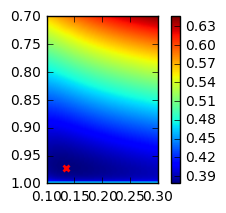

In [159]:
(pi, s, k) = grid_search_fit(x, h_test)
(i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
print 'pi:',pi[i_star]
print 's:',s[j_star]
print 'kld:',k[i_star,j_star]

plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(s[j_star], pi[i_star], 'x',color='r',ms=5.0,mew=2.0)
plt.imshow(k,extent=(s.min(),s.max(),pi.max(), pi.min()))
plt.colorbar()
# plt.xlabel('')
# plt.ylabel('$\pi$')
plt.savefig('grid_search.eps',dpi=600,bbox_inches='tight',transparent=True)

## ROC computation

### continuous

(0.0, 1.0, 0.0, 1.0)

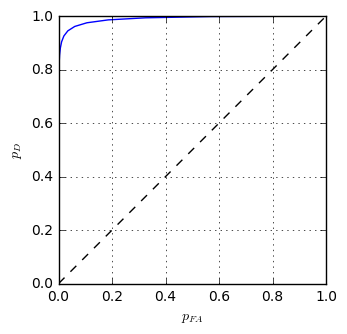

In [160]:
x = np.linspace(0,1,100)

p_fa = np.exp(-55.6*x)
p_d = np.exp(-x*x/(2*0.18*0.18))

plt.figure(figsize=(3.45,3.45))
plt.plot(p_fa,p_d)
plt.grid()
plt.xlabel('$p_{FA}$')
plt.ylabel('$p_{D}$')
plt.plot([0,1],[0,1],'--',color='k')
plt.axis('equal')

# plt.yscale('log')
# plt.xscale('log')


## individual images

0.0 0.585367838542


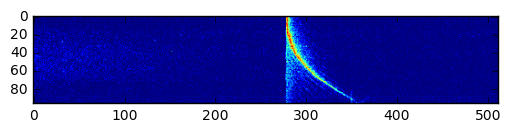

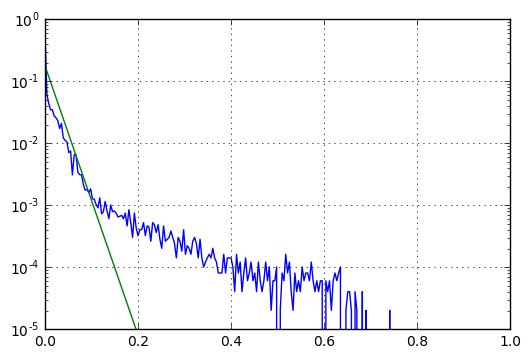

In [161]:
idx = np.random.randint(0,len(image_list_1))
image = (1/255.0)*imread(image_list_1[idx],as_grey = True)
bins = np.linspace(0, 1.0, 256 )
hi = np.histogram(image[:],bins)
plt.figure()
plt.imshow(image.transpose())

x = hi[1][:-1].astype(np.float64)
h_test = hi[0][:].astype(np.float64)
h_test/=(0.0+np.sum(h_test))
print np.min(h_test), np.max(h_test)

p_bg = expon.pdf(hi[1][:-1], 0, 0.02)  # theoretical distribution (normalized)
p_bg/=np.sum(p_bg)

plt.figure()
plt.plot(hi[1][:-1],h_test)
plt.plot(hi[1][:-1],p_bg)
plt.xlim([0,1])
plt.ylim([1e-5,1e0])
plt.yscale('log')
plt.grid()



pi: 0.963636363636
s: 0.188888888889
kld: 0.417021615659


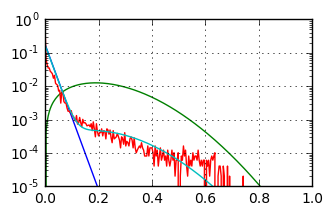

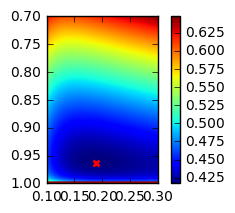

In [162]:
(pi, s, k) = grid_search_fit(x,h_test, 100)
(i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
print 'pi:',pi[i_star]
print 's:',s[j_star]
print 'kld:',k[i_star,j_star]
s1 = s[j_star]
pi0 = pi[i_star]

p_o = rayleigh.pdf(x,0,s1)
p_o/=np.sum(p_o)
p_approx = pi0*p_bg + (1-pi0)*p_o

# mixture
plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(x, p_bg)
plt.plot(x, p_o)
plt.plot(x, h_test)
plt.plot(x, p_approx)
plt.xlim([0,1])
plt.ylim([1e-5,1e0])
plt.yscale('log')
plt.grid()

# grid search
plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(s[j_star], pi[i_star], 'x',color='r',ms=5.0,mew=2.0)
plt.imshow(k,extent=(s.min(),s.max(),pi.max(), pi.min()))
plt.colorbar()
# plt.xlabel('')
# plt.ylabel('$\pi$')
plt.savefig('grid_search.eps',dpi=600,bbox_inches='tight',transparent=True)

# ROC

# classified image

0 & 50 & 0.967 & 0.122 & 0.385 \\ 
1 & 50 & 0.967 & 0.233 & 0.409 \\ 
2 & 50 & 0.967 & 0.189 & 0.417 \\ 
3 & 50 & 0.967 & 0.144 & 0.382 \\ 
4 & 50 & 0.933 & 0.167 & 0.396 \\ 
5 & 50 & 0.967 & 0.122 & 0.394 \\ 
6 & 50 & 0.767 & 0.167 & 0.306 \\ 
7 & 50 & 1.000 & 0.100 & 0.429 \\ 
8 & 50 & 0.967 & 0.122 & 0.371 \\ 
9 & 50 & 0.967 & 0.122 & 0.379 \\ 


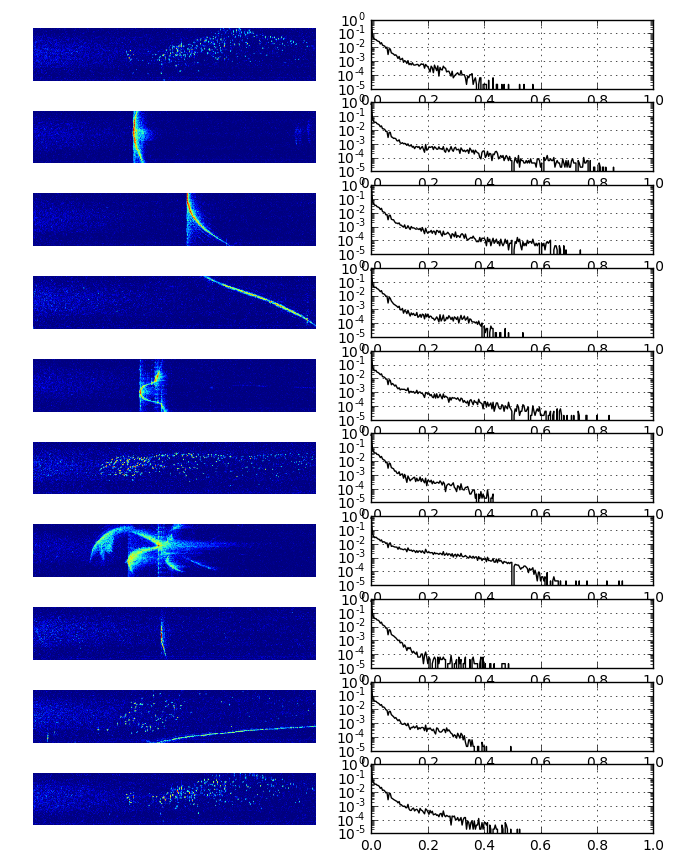

In [163]:
# %%timeit
plt.figure(figsize=(8,10.5))

for idx in range(0,len(image_list_1)):
    image = (1/255.0)*imread(image_list_1[idx],as_grey = True)
    bins = np.linspace(0, 1.0, 256 )
    hi = np.histogram(image[:],bins)
    
    x = hi[1][:-1].astype(np.float64)
    h_test = hi[0][:].astype(np.float64)
    h_test/=(0.0+np.sum(h_test))
    
    (pi, s, k) = grid_search_fit(x,h_test, 10)
    
    (i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
#     print idx, ' - ','pi:',pi[i_star], 's:',s[j_star], 'kld:',k[i_star,j_star]
    print '%d & 50 & %.3f & %.3f & %.3f \\\\ ' % (idx, pi[i_star], s[j_star], k[i_star, j_star]) # latex table

    plt.subplot(len(image_list_1),2,2*idx+1)
    plt.imshow(image.transpose())
    plt.axis('off')

    plt.subplot(len(image_list_1),2,2*idx+2)
    plt.plot(x, h_test,color='k')
    plt.xlim([0,1])
    plt.ylim([1e-5,1e0])
    plt.yscale('log')
    plt.grid()

plt.savefig('test.eps',dpi=600,bbox_inches='tight',transparent=True)


In [146]:
import sonar
import didson